In [1]:
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import numpy as np
import keras
from keras import backend as K
from keras.layers import Input, Dense, Conv2D, MaxPooling2D,\
        UpSampling2D, Lambda, Activation, merge
from keras.layers.core import Dropout, Reshape, Flatten
from keras.layers.merge import Concatenate
from keras.layers.normalization import BatchNormalization
from keras.models import Model, Sequential
from keras.applications.vgg16 import VGG16
from keras.layers.advanced_activations import LeakyReLU
from keras.initializers import Initializer
from keras.regularizers import l2
from keras.optimizers import Adam, RMSprop
from keras.utils import plot_model
from keras.datasets import mnist
from keras.utils import to_categorical
import pydot
import graphviz
from PIL import Image
import scipy.misc
import matplotlib.pyplot as plt
from scipy.misc import imsave
import bcolz
import math

Using TensorFlow backend.


In [2]:
'''LOAD MNIST'''
(x_all, y_all), (x_test, y_test) = mnist.load_data()
x_all = x_all/255.0
x_test = x_test/255.0

x_train = x_all[:50000]
y_train = y_all[:50000]
x_validate = x_all[50000:]
y_validate = y_all[50000:]

x_train = np.expand_dims(x_train, axis=3)
x_validate = np.expand_dims(x_validate, axis=3)
x_test = np.expand_dims(x_test, axis=3)

num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_validate = to_categorical(y_validate, num_classes)
y_test = to_categorical(y_test, num_classes)

input_shape = x_train.shape

## Define and Train Classifier, Freeze Classifier After Training

In [3]:
classifier_inp = Input(x_train.shape[1:])
conv1 = Conv2D(32, (3, 3),
                      activation = 'relu',
                      padding = 'same')(classifier_inp)
conv2 = Conv2D(64, (3, 3),
                      activation = 'relu',
                      padding = 'same')(conv1)
classifier = MaxPooling2D()(conv2)
classifier = Dropout(0.25)(classifier)
classifier = Flatten()(classifier)
classifier = Dense(128, activation = 'relu')(classifier)
classifier = Dropout(0.5)(classifier)
classifier = Dense(num_classes, activation = 'softmax')(classifier)
classifier = Model(classifier_inp,classifier)

In [4]:
classifier.compile(Adam(),
                   loss = 'categorical_crossentropy',
                   metrics=['accuracy'])

In [5]:
classifier.fit(x_train, y_train,
          batch_size = 512,
          epochs = 100,
          verbose = 1,
          validation_data = (x_validate, y_validate))

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 3s - loss: 0.4553 - acc: 0.8581 - val_loss: 0.1088 - val_acc: 0.9683
Epoch 2/100
50000/50000 [==============================] - 2s - loss: 0.1332 - acc: 0.9617 - val_loss: 0.0667 - val_acc: 0.9800
Epoch 3/100
50000/50000 [==============================] - 2s - loss: 0.0916 - acc: 0.9722 - val_loss: 0.0573 - val_acc: 0.9831
Epoch 4/100
50000/50000 [==============================] - 2s - loss: 0.0710 - acc: 0.9781 - val_loss: 0.0497 - val_acc: 0.9863
Epoch 5/100
50000/50000 [==============================] - 2s - loss: 0.0621 - acc: 0.9811 - val_loss: 0.0445 - val_acc: 0.9868
Epoch 6/100
50000/50000 [==============================] - 2s - loss: 0.0521 - acc: 0.9841 - val_loss: 0.0447 - val_acc: 0.9879
Epoch 7/100
50000/50000 [==============================] - 2s - loss: 0.0500 - acc: 0.9847 - val_loss: 0.0382 - val_acc: 0.9898
Epoch 8/100
50000/50000 [=============================

In [6]:
classifier_accuracy = classifier.evaluate(x_test, y_test, verbose=0)
print('Classifier accuracy: %.2f%%' % (classifier_accuracy[1] * 100.0))

Classifier accuracy: 99.39%


In [7]:
'''Make our classifier not trainable'''
classifier.trainable = False
for layer in classifier.layers:
    layer.trainable = False

## Define Generative Model and Train It

In [8]:
'''Prepare perception target - Functional'''
percept = Model(classifier_inp,conv2)

In [9]:
percept_train = percept.predict(x_train)
percept_validate = percept.predict(x_validate)

percept_train.shape, percept_validate.shape

((50000, 28, 28, 64), (10000, 28, 28, 64))

In [10]:
'''Prepare adversarial target'''
y0_train = np.zeros((x_train.shape[0],10))
y0_train[:,0] = 1.0
y0_validate = np.zeros((x_validate.shape[0],10))
y0_validate[:,0] = 1.0

y1_train = np.zeros((x_train.shape[0],10))
y1_train[:,1] = 1.0
y1_validate = np.zeros((x_validate.shape[0],10))
y1_validate[:,1] = 1.0

y2_train = np.zeros((x_train.shape[0],10))
y2_train[:,2] = 1.0
y2_validate = np.zeros((x_validate.shape[0],10))
y2_validate[:,2] = 1.0

y3_train = np.zeros((x_train.shape[0],10))
y3_train[:,3] = 1.0
y3_validate = np.zeros((x_validate.shape[0],10))
y3_validate[:,3] = 1.0

y4_train = np.zeros((x_train.shape[0],10))
y4_train[:,4] = 1.0
y4_validate = np.zeros((x_validate.shape[0],10))
y4_validate[:,4] = 1.0

y5_train = np.zeros((x_train.shape[0],10))
y5_train[:,5] = 1.0
y5_validate = np.zeros((x_validate.shape[0],10))
y5_validate[:,5] = 1.0

y6_train = np.zeros((x_train.shape[0],10))
y6_train[:,6] = 1.0
y6_validate = np.zeros((x_validate.shape[0],10))
y6_validate[:,6] = 1.0

y7_train = np.zeros((x_train.shape[0],10))
y7_train[:,7] = 1.0
y7_validate = np.zeros((x_validate.shape[0],10))
y7_validate[:,7] = 1.0

y8_train = np.zeros((x_train.shape[0],10))
y8_train[:,8] = 1.0
y8_validate = np.zeros((x_validate.shape[0],10))
y8_validate[:,8] = 1.0

y9_train = np.zeros((x_train.shape[0],10))
y9_train[:,9] = 1.0
y9_validate = np.zeros((x_validate.shape[0],10))
y9_validate[:,9] = 1.0

In [11]:
def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, (size,size), strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    if activation == True:
        x = Activation('relu')(x)
    return x

def residual_block(blockInput, num_filters=64):
    x = convolution_block(blockInput, num_filters, 3)
    x = convolution_block(x, num_filters, 3, activation=False)
    x = merge([x, blockInput], mode='sum')
    return x

def upsampling_block(x, filters, size):
    x = UpSampling2D()(x)
    x = Conv2D(filters, (size,size), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

In [12]:
classifier.trainable = False
for layer in classifier.layers:
    layer.trainable = False
    
percept.trainable = False
for layer in percept.layers:
    percept.trainable = False

'''NETWORK #0'''
inp0 = Input(x_train.shape[1:])
x0 = convolution_block(inp0, 64, 9)
x0 = residual_block(x0)
x0 = residual_block(x0)
x0 = residual_block(x0)
x0 = residual_block(x0)
out0 = Conv2D(1, (9,9), activation = 'sigmoid', padding='same')(x0)
percept0 = percept(out0)
y0 = classifier(out0)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:11: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.5/dist-packages/keras/legacy/layers.py:458: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)


In [13]:
model0 = Model(inp0, [percept0, y0])

In [14]:
model0.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 28, 28, 1)     0                                            
____________________________________________________________________________________________________
conv2d_3 (Conv2D)                (None, 28, 28, 64)    5248        input_2[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 28, 28, 64)    256         conv2d_3[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 28, 28, 64)    0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

In [15]:
plot_model(model0, to_file='model0.png')

In [16]:
model0.compile(Adam(), 
            loss = {'model_2': 'mean_squared_error', 'model_1': 'categorical_crossentropy'},
            loss_weights = {'model_2': 250.0, 'model_1': 1.0}) #model_2 = perception, model_1 = classifier

In [17]:
model0.optimizer = Adam(0.00001)
model0.loss_weights = {'model_2': 250.0, 'model_1': 1.0} #model_2 = perception, model_1 = classifier
model0.fit(x_train, {'model_2': percept_train, 'model_1':y0_train}, 
        validation_data = (x_validate, {'model_2': percept_validate,'model_1': y0_validate}),
        epochs = 1000,
        batch_size = 512,
        shuffle = True,
        #callbacks = [model0_loss]
       )

Train on 50000 samples, validate on 10000 samples
Epoch 1/1000
50000/50000 [==============================] - 38s - loss: 11.5771 - model_2_loss: 0.0251 - model_1_loss: 5.3049 - val_loss: 11.4807 - val_model_2_loss: 0.0139 - val_model_1_loss: 7.9984
Epoch 2/1000
50000/50000 [==============================] - 37s - loss: 5.5380 - model_2_loss: 0.0199 - model_1_loss: 0.5526 - val_loss: 6.1284 - val_model_2_loss: 0.0136 - val_model_1_loss: 2.7343
Epoch 3/1000
50000/50000 [==============================] - 37s - loss: 4.4762 - model_2_loss: 0.0167 - model_1_loss: 0.2958 - val_loss: 5.0814 - val_model_2_loss: 0.0133 - val_model_1_loss: 1.7667
Epoch 4/1000
50000/50000 [==============================] - 38s - loss: 3.9075 - model_2_loss: 0.0147 - model_1_loss: 0.2333 - val_loss: 4.4987 - val_model_2_loss: 0.0130 - val_model_1_loss: 1.2460
Epoch 5/1000
50000/50000 [==============================] - 37s - loss: 3.5464 - model_2_loss: 0.0134 - model_1_loss: 0.2059 - val_loss: 3.4011 - val_model_

50000/50000 [==============================] - 38s - loss: 1.2552 - model_2_loss: 0.0047 - model_1_loss: 0.0896 - val_loss: 1.1533 - val_model_2_loss: 0.0045 - val_model_1_loss: 0.0179
Epoch 83/1000
50000/50000 [==============================] - 38s - loss: 1.2487 - model_2_loss: 0.0046 - model_1_loss: 0.0897 - val_loss: 1.1867 - val_model_2_loss: 0.0047 - val_model_1_loss: 0.0082
Epoch 84/1000
50000/50000 [==============================] - 38s - loss: 1.2457 - model_2_loss: 0.0046 - model_1_loss: 0.0884 - val_loss: 1.1628 - val_model_2_loss: 0.0046 - val_model_1_loss: 0.0148
Epoch 85/1000
50000/50000 [==============================] - 38s - loss: 1.2422 - model_2_loss: 0.0046 - model_1_loss: 0.0866 - val_loss: 1.1542 - val_model_2_loss: 0.0046 - val_model_1_loss: 0.0136
Epoch 86/1000
50000/50000 [==============================] - 38s - loss: 1.2408 - model_2_loss: 0.0046 - model_1_loss: 0.0866 - val_loss: 1.1600 - val_model_2_loss: 0.0046 - val_model_1_loss: 0.0130
Epoch 87/1000
50000

50000/50000 [==============================] - 38s - loss: 1.1135 - model_2_loss: 0.0041 - model_1_loss: 0.0769 - val_loss: 1.0629 - val_model_2_loss: 0.0042 - val_model_1_loss: 0.0066
Epoch 165/1000
50000/50000 [==============================] - 38s - loss: 1.1162 - model_2_loss: 0.0042 - model_1_loss: 0.0783 - val_loss: 1.0569 - val_model_2_loss: 0.0042 - val_model_1_loss: 0.0071
Epoch 166/1000
50000/50000 [==============================] - 38s - loss: 1.1154 - model_2_loss: 0.0042 - model_1_loss: 0.0771 - val_loss: 1.0498 - val_model_2_loss: 0.0042 - val_model_1_loss: 0.0113
Epoch 167/1000
50000/50000 [==============================] - 38s - loss: 1.1125 - model_2_loss: 0.0041 - model_1_loss: 0.0786 - val_loss: 1.0704 - val_model_2_loss: 0.0043 - val_model_1_loss: 0.0058
Epoch 168/1000
50000/50000 [==============================] - 38s - loss: 1.1158 - model_2_loss: 0.0042 - model_1_loss: 0.0782 - val_loss: 1.0791 - val_model_2_loss: 0.0043 - val_model_1_loss: 0.0051
Epoch 169/1000


50000/50000 [==============================] - 38s - loss: 1.0775 - model_2_loss: 0.0040 - model_1_loss: 0.0726 - val_loss: 1.0008 - val_model_2_loss: 0.0040 - val_model_1_loss: 0.0108
Epoch 206/1000
50000/50000 [==============================] - 38s - loss: 1.0805 - model_2_loss: 0.0040 - model_1_loss: 0.0744 - val_loss: 1.0113 - val_model_2_loss: 0.0040 - val_model_1_loss: 0.0095
Epoch 207/1000
50000/50000 [==============================] - 38s - loss: 1.0829 - model_2_loss: 0.0040 - model_1_loss: 0.0750 - val_loss: 1.0142 - val_model_2_loss: 0.0040 - val_model_1_loss: 0.0083
Epoch 208/1000
50000/50000 [==============================] - 38s - loss: 1.0785 - model_2_loss: 0.0040 - model_1_loss: 0.0747 - val_loss: 1.0553 - val_model_2_loss: 0.0042 - val_model_1_loss: 0.0051
Epoch 209/1000
50000/50000 [==============================] - 38s - loss: 1.0804 - model_2_loss: 0.0040 - model_1_loss: 0.0741 - val_loss: 0.9923 - val_model_2_loss: 0.0039 - val_model_1_loss: 0.0123
Epoch 210/1000


50000/50000 [==============================] - 38s - loss: 1.0573 - model_2_loss: 0.0039 - model_1_loss: 0.0726 - val_loss: 1.0099 - val_model_2_loss: 0.0040 - val_model_1_loss: 0.0048
Epoch 247/1000
50000/50000 [==============================] - 38s - loss: 1.0551 - model_2_loss: 0.0039 - model_1_loss: 0.0727 - val_loss: 1.0076 - val_model_2_loss: 0.0040 - val_model_1_loss: 0.0047
Epoch 248/1000
50000/50000 [==============================] - 38s - loss: 1.0546 - model_2_loss: 0.0039 - model_1_loss: 0.0720 - val_loss: 0.9992 - val_model_2_loss: 0.0040 - val_model_1_loss: 0.0062
Epoch 249/1000
50000/50000 [==============================] - 38s - loss: 1.0503 - model_2_loss: 0.0039 - model_1_loss: 0.0694 - val_loss: 0.9992 - val_model_2_loss: 0.0040 - val_model_1_loss: 0.0061
Epoch 250/1000
50000/50000 [==============================] - 38s - loss: 1.0557 - model_2_loss: 0.0039 - model_1_loss: 0.0729 - val_loss: 0.9732 - val_model_2_loss: 0.0038 - val_model_1_loss: 0.0229
Epoch 251/1000


50000/50000 [==============================] - 38s - loss: 1.0307 - model_2_loss: 0.0038 - model_1_loss: 0.0688 - val_loss: 0.9485 - val_model_2_loss: 0.0037 - val_model_1_loss: 0.0117
Epoch 288/1000
50000/50000 [==============================] - 38s - loss: 1.0322 - model_2_loss: 0.0038 - model_1_loss: 0.0704 - val_loss: 0.9818 - val_model_2_loss: 0.0039 - val_model_1_loss: 0.0047
Epoch 289/1000
50000/50000 [==============================] - 38s - loss: 1.0327 - model_2_loss: 0.0039 - model_1_loss: 0.0701 - val_loss: 0.9551 - val_model_2_loss: 0.0038 - val_model_1_loss: 0.0080
Epoch 290/1000
50000/50000 [==============================] - 38s - loss: 1.0325 - model_2_loss: 0.0039 - model_1_loss: 0.0691 - val_loss: 0.9716 - val_model_2_loss: 0.0039 - val_model_1_loss: 0.0061
Epoch 291/1000
50000/50000 [==============================] - 38s - loss: 1.0331 - model_2_loss: 0.0038 - model_1_loss: 0.0729 - val_loss: 0.9685 - val_model_2_loss: 0.0038 - val_model_1_loss: 0.0068
Epoch 292/1000


50000/50000 [==============================] - 38s - loss: 1.0132 - model_2_loss: 0.0038 - model_1_loss: 0.0680 - val_loss: 0.9742 - val_model_2_loss: 0.0039 - val_model_1_loss: 0.0039
Epoch 329/1000
50000/50000 [==============================] - 38s - loss: 1.0110 - model_2_loss: 0.0038 - model_1_loss: 0.0678 - val_loss: 0.9796 - val_model_2_loss: 0.0039 - val_model_1_loss: 0.0039
Epoch 330/1000
50000/50000 [==============================] - 38s - loss: 1.0124 - model_2_loss: 0.0038 - model_1_loss: 0.0679 - val_loss: 0.9274 - val_model_2_loss: 0.0037 - val_model_1_loss: 0.0113
Epoch 331/1000
50000/50000 [==============================] - 38s - loss: 1.0119 - model_2_loss: 0.0038 - model_1_loss: 0.0680 - val_loss: 0.9528 - val_model_2_loss: 0.0038 - val_model_1_loss: 0.0050
Epoch 332/1000
50000/50000 [==============================] - 38s - loss: 1.0160 - model_2_loss: 0.0038 - model_1_loss: 0.0692 - val_loss: 0.9440 - val_model_2_loss: 0.0037 - val_model_1_loss: 0.0068
Epoch 333/1000


50000/50000 [==============================] - 38s - loss: 0.9985 - model_2_loss: 0.0037 - model_1_loss: 0.0658 - val_loss: 0.9251 - val_model_2_loss: 0.0037 - val_model_1_loss: 0.0087
Epoch 370/1000
50000/50000 [==============================] - 38s - loss: 0.9945 - model_2_loss: 0.0037 - model_1_loss: 0.0670 - val_loss: 0.9735 - val_model_2_loss: 0.0039 - val_model_1_loss: 0.0025
Epoch 371/1000
50000/50000 [==============================] - 38s - loss: 0.9972 - model_2_loss: 0.0037 - model_1_loss: 0.0679 - val_loss: 0.9628 - val_model_2_loss: 0.0038 - val_model_1_loss: 0.0032
Epoch 372/1000
50000/50000 [==============================] - 38s - loss: 0.9971 - model_2_loss: 0.0037 - model_1_loss: 0.0694 - val_loss: 0.9312 - val_model_2_loss: 0.0037 - val_model_1_loss: 0.0064
Epoch 373/1000
50000/50000 [==============================] - 38s - loss: 0.9978 - model_2_loss: 0.0037 - model_1_loss: 0.0670 - val_loss: 0.9510 - val_model_2_loss: 0.0038 - val_model_1_loss: 0.0042
Epoch 374/1000


50000/50000 [==============================] - 38s - loss: 0.9807 - model_2_loss: 0.0037 - model_1_loss: 0.0659 - val_loss: 0.9249 - val_model_2_loss: 0.0037 - val_model_1_loss: 0.0044
Epoch 411/1000
50000/50000 [==============================] - 38s - loss: 0.9848 - model_2_loss: 0.0037 - model_1_loss: 0.0674 - val_loss: 0.9116 - val_model_2_loss: 0.0036 - val_model_1_loss: 0.0065
Epoch 412/1000
50000/50000 [==============================] - 38s - loss: 0.9835 - model_2_loss: 0.0037 - model_1_loss: 0.0680 - val_loss: 0.9408 - val_model_2_loss: 0.0038 - val_model_1_loss: 0.0033
Epoch 413/1000
50000/50000 [==============================] - 38s - loss: 0.9776 - model_2_loss: 0.0036 - model_1_loss: 0.0673 - val_loss: 0.9198 - val_model_2_loss: 0.0037 - val_model_1_loss: 0.0047
Epoch 414/1000
50000/50000 [==============================] - 38s - loss: 0.9813 - model_2_loss: 0.0037 - model_1_loss: 0.0663 - val_loss: 0.9508 - val_model_2_loss: 0.0038 - val_model_1_loss: 0.0026
Epoch 415/1000


50000/50000 [==============================] - 38s - loss: 0.9747 - model_2_loss: 0.0036 - model_1_loss: 0.0684 - val_loss: 0.9252 - val_model_2_loss: 0.0037 - val_model_1_loss: 0.0035
Epoch 452/1000
50000/50000 [==============================] - 38s - loss: 0.9694 - model_2_loss: 0.0036 - model_1_loss: 0.0653 - val_loss: 0.9179 - val_model_2_loss: 0.0037 - val_model_1_loss: 0.0035
Epoch 453/1000
50000/50000 [==============================] - 38s - loss: 0.9673 - model_2_loss: 0.0036 - model_1_loss: 0.0651 - val_loss: 0.9267 - val_model_2_loss: 0.0037 - val_model_1_loss: 0.0029
Epoch 454/1000
50000/50000 [==============================] - 38s - loss: 0.9685 - model_2_loss: 0.0036 - model_1_loss: 0.0643 - val_loss: 0.9063 - val_model_2_loss: 0.0036 - val_model_1_loss: 0.0051
Epoch 455/1000
50000/50000 [==============================] - 38s - loss: 0.9657 - model_2_loss: 0.0036 - model_1_loss: 0.0640 - val_loss: 0.8998 - val_model_2_loss: 0.0036 - val_model_1_loss: 0.0059
Epoch 456/1000


50000/50000 [==============================] - 38s - loss: 0.9558 - model_2_loss: 0.0036 - model_1_loss: 0.0634 - val_loss: 0.8953 - val_model_2_loss: 0.0036 - val_model_1_loss: 0.0047
Epoch 493/1000
50000/50000 [==============================] - 38s - loss: 0.9564 - model_2_loss: 0.0036 - model_1_loss: 0.0648 - val_loss: 0.9210 - val_model_2_loss: 0.0037 - val_model_1_loss: 0.0028
Epoch 494/1000
50000/50000 [==============================] - 38s - loss: 0.9583 - model_2_loss: 0.0036 - model_1_loss: 0.0641 - val_loss: 0.9013 - val_model_2_loss: 0.0036 - val_model_1_loss: 0.0037
Epoch 495/1000
50000/50000 [==============================] - 38s - loss: 0.9590 - model_2_loss: 0.0036 - model_1_loss: 0.0659 - val_loss: 0.8906 - val_model_2_loss: 0.0035 - val_model_1_loss: 0.0058
Epoch 496/1000
50000/50000 [==============================] - 38s - loss: 0.9570 - model_2_loss: 0.0036 - model_1_loss: 0.0658 - val_loss: 0.9311 - val_model_2_loss: 0.0037 - val_model_1_loss: 0.0018
Epoch 497/1000


50000/50000 [==============================] - 38s - loss: 0.9481 - model_2_loss: 0.0035 - model_1_loss: 0.0632 - val_loss: 0.8727 - val_model_2_loss: 0.0035 - val_model_1_loss: 0.0077
Epoch 534/1000
50000/50000 [==============================] - 38s - loss: 0.9474 - model_2_loss: 0.0035 - model_1_loss: 0.0638 - val_loss: 0.8804 - val_model_2_loss: 0.0035 - val_model_1_loss: 0.0067
Epoch 535/1000
50000/50000 [==============================] - 38s - loss: 0.9453 - model_2_loss: 0.0035 - model_1_loss: 0.0624 - val_loss: 0.9139 - val_model_2_loss: 0.0036 - val_model_1_loss: 0.0024
Epoch 536/1000
50000/50000 [==============================] - 38s - loss: 0.9462 - model_2_loss: 0.0035 - model_1_loss: 0.0637 - val_loss: 0.9180 - val_model_2_loss: 0.0037 - val_model_1_loss: 0.0022
Epoch 537/1000
50000/50000 [==============================] - 38s - loss: 0.9490 - model_2_loss: 0.0035 - model_1_loss: 0.0649 - val_loss: 0.8885 - val_model_2_loss: 0.0035 - val_model_1_loss: 0.0046
Epoch 538/1000


50000/50000 [==============================] - 38s - loss: 0.9394 - model_2_loss: 0.0035 - model_1_loss: 0.0640 - val_loss: 0.9006 - val_model_2_loss: 0.0036 - val_model_1_loss: 0.0035
Epoch 575/1000
50000/50000 [==============================] - 38s - loss: 0.9396 - model_2_loss: 0.0035 - model_1_loss: 0.0639 - val_loss: 0.8777 - val_model_2_loss: 0.0035 - val_model_1_loss: 0.0043
Epoch 576/1000
50000/50000 [==============================] - 38s - loss: 0.9416 - model_2_loss: 0.0035 - model_1_loss: 0.0638 - val_loss: 0.9072 - val_model_2_loss: 0.0036 - val_model_1_loss: 0.0021
Epoch 577/1000
50000/50000 [==============================] - 38s - loss: 0.9358 - model_2_loss: 0.0035 - model_1_loss: 0.0620 - val_loss: 0.8683 - val_model_2_loss: 0.0034 - val_model_1_loss: 0.0060
Epoch 578/1000
50000/50000 [==============================] - 38s - loss: 0.9363 - model_2_loss: 0.0035 - model_1_loss: 0.0624 - val_loss: 0.8858 - val_model_2_loss: 0.0035 - val_model_1_loss: 0.0035
Epoch 579/1000


50000/50000 [==============================] - 38s - loss: 0.9277 - model_2_loss: 0.0035 - model_1_loss: 0.0615 - val_loss: 0.9188 - val_model_2_loss: 0.0037 - val_model_1_loss: 0.0014
Epoch 616/1000
50000/50000 [==============================] - 38s - loss: 0.9315 - model_2_loss: 0.0035 - model_1_loss: 0.0629 - val_loss: 0.9197 - val_model_2_loss: 0.0037 - val_model_1_loss: 0.0014
Epoch 617/1000
50000/50000 [==============================] - 38s - loss: 0.9328 - model_2_loss: 0.0035 - model_1_loss: 0.0630 - val_loss: 0.9050 - val_model_2_loss: 0.0036 - val_model_1_loss: 0.0016
Epoch 618/1000
50000/50000 [==============================] - 38s - loss: 0.9245 - model_2_loss: 0.0035 - model_1_loss: 0.0597 - val_loss: 0.8757 - val_model_2_loss: 0.0035 - val_model_1_loss: 0.0040
Epoch 619/1000
50000/50000 [==============================] - 38s - loss: 0.9300 - model_2_loss: 0.0035 - model_1_loss: 0.0611 - val_loss: 0.8932 - val_model_2_loss: 0.0036 - val_model_1_loss: 0.0021
Epoch 620/1000


50000/50000 [==============================] - 38s - loss: 0.9225 - model_2_loss: 0.0034 - model_1_loss: 0.0615 - val_loss: 0.8400 - val_model_2_loss: 0.0033 - val_model_1_loss: 0.0096
Epoch 657/1000
50000/50000 [==============================] - 38s - loss: 0.9240 - model_2_loss: 0.0035 - model_1_loss: 0.0615 - val_loss: 0.8452 - val_model_2_loss: 0.0034 - val_model_1_loss: 0.0076
Epoch 658/1000
50000/50000 [==============================] - 38s - loss: 0.9250 - model_2_loss: 0.0034 - model_1_loss: 0.0636 - val_loss: 0.9174 - val_model_2_loss: 0.0037 - val_model_1_loss: 7.4275e-04
Epoch 659/1000
50000/50000 [==============================] - 38s - loss: 0.9260 - model_2_loss: 0.0035 - model_1_loss: 0.0624 - val_loss: 0.8615 - val_model_2_loss: 0.0034 - val_model_1_loss: 0.0043
Epoch 660/1000
50000/50000 [==============================] - 38s - loss: 0.9248 - model_2_loss: 0.0034 - model_1_loss: 0.0642 - val_loss: 0.8868 - val_model_2_loss: 0.0035 - val_model_1_loss: 0.0025
Epoch 661/1

KeyboardInterrupt: 

In [18]:
generator = Model(inp0, out0)

In [19]:
x_fake = generator.predict(x_test)
x_fake.shape

(10000, 28, 28, 1)

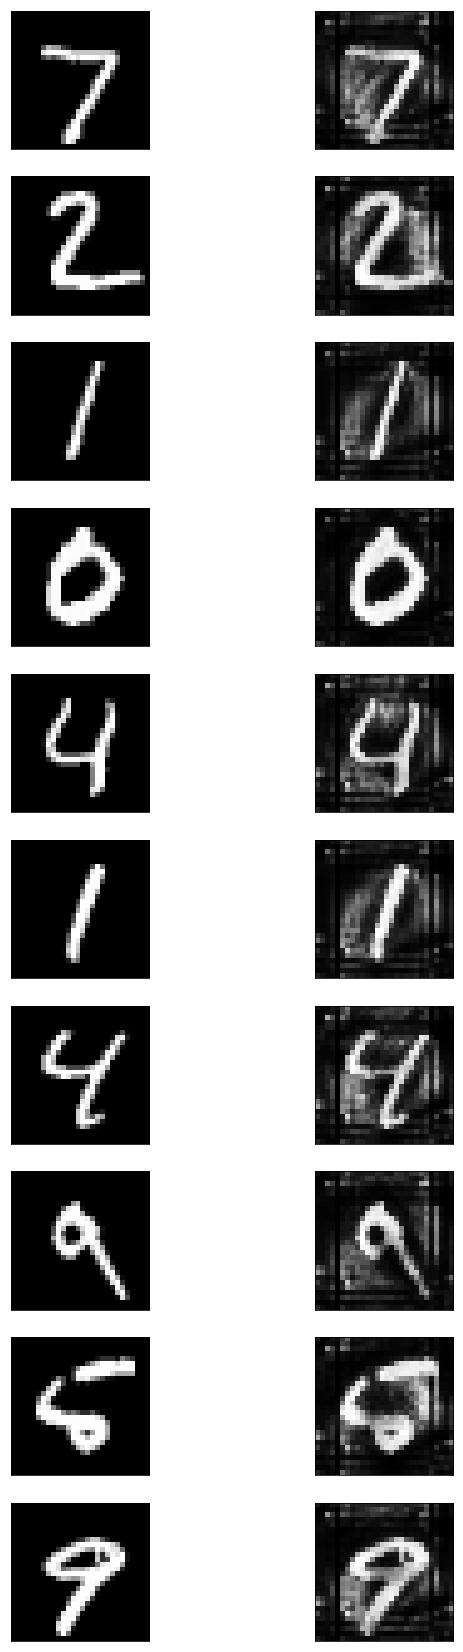

In [20]:
'''Lets see some of the generated images'''
num = 10
fig,axis = plt.subplots(nrows = num, ncols=2, figsize=(10,30))
for i in range(num):
    axis[i,0].imshow(x_test[i,:,:,0], cmap='gray')
    axis[i,0].get_xaxis().set_visible(False)
    axis[i,0].get_yaxis().set_visible(False)
    axis[i,1].imshow(x_fake[i,:,:,0], cmap='gray')
    axis[i,1].get_xaxis().set_visible(False)
    axis[i,1].get_yaxis().set_visible(False)

In [21]:
classifier_accuracy_test = classifier.evaluate(x_test, y_test, verbose=0)
print('Classifier accuracy on test set: %.2f%%' % (classifier_accuracy_test[1] * 100.0))

Classifier accuracy on test set: 99.39%


In [22]:
classifier_accuracy_fake = classifier.evaluate(x_fake, y_test, verbose=0)
print('Classifier accuracy on fake test set: %.2f%%' % (classifier_accuracy_fake[1] * 100.0))

Classifier accuracy on fake test set: 9.84%


## Let's see how the classifier is fooled

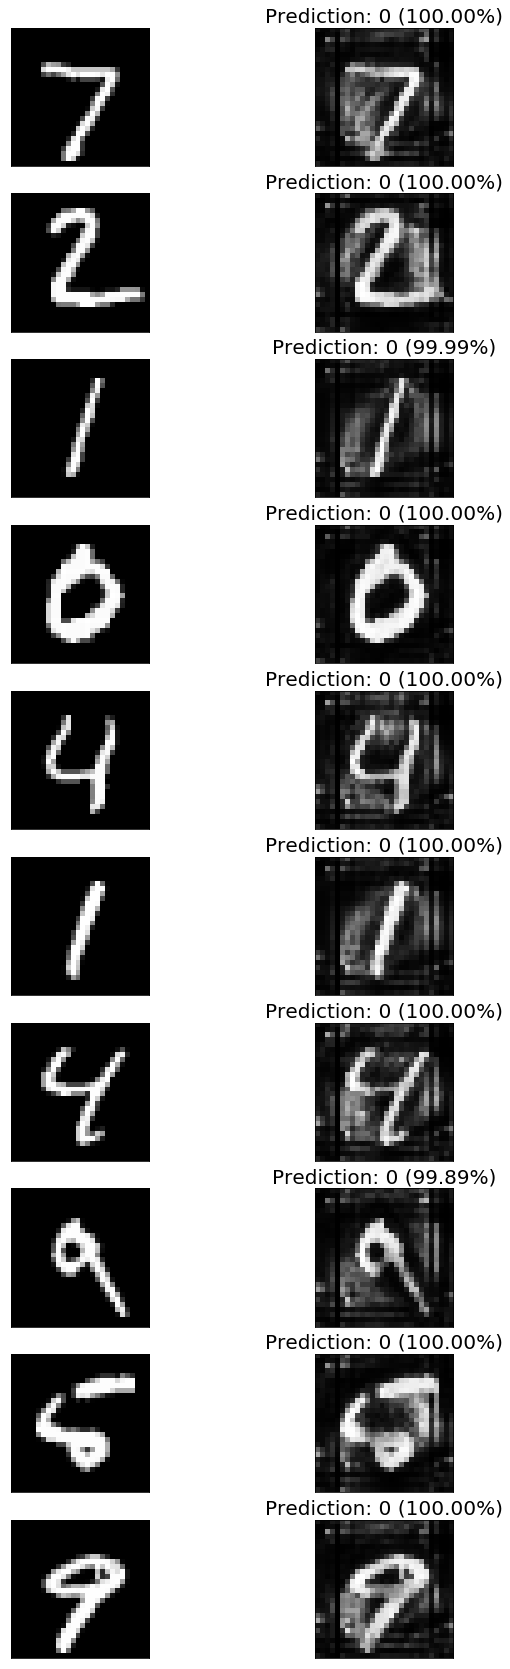

In [23]:
fake_predictions = classifier.predict(x_fake)
fig,axis = plt.subplots(nrows = num, ncols=2, figsize=(10,30))
for i in range(num):
    axis[i,0].imshow(x_test[i,:,:,0], cmap='gray')
    axis[i,0].get_xaxis().set_visible(False)
    axis[i,0].get_yaxis().set_visible(False)
    axis[i,1].imshow(x_fake[i,:,:,0], cmap='gray')
    axis[i,1].get_xaxis().set_visible(False)
    axis[i,1].get_yaxis().set_visible(False)
    title = 'Prediction: ' + str(np.argmax(fake_predictions[i]))\
            + ' (' +\
            '%.2f%%' % (np.amax(fake_predictions[i])*100.0)\
            + ')'
    axis[i,1].set_title(title, fontsize = 20)

In [24]:
generator.save('generator_model.h5')
classifier.save('mnist_classifier_model.h5')